### Import Libraries
Here we used few python files which has our helper functions
1. sentenceSegmentation - Punkt sentence segmenter is used
2. tokenization - Penn Tree Bank Toenizer is used
3. inflectionReduction - Lemmatization is used
4. stopwordRemoval - nltk english stopwords are used
5. informationRetrieval - Builts the document index and ranking the documents
6. evaluationAllMetrics - This is to plot all the metrics values at different k
7. tfidf - This transforms the count matrix to tfidf matrix 
8. evaluation - It has all the individual metric calculation functions
9. util -  required packages to run the above python files

In [2]:
from sentenceSegmentation import SentenceSegmentation
from tokenization import Tokenization
from inflectionReduction import InflectionReduction
from stopwordRemoval import StopwordRemoval
from informationRetrieval import InformationRetrieval
from evaluationAllMetrics import Evaluation_metrics # this is to plot and table of results at every k
from tfidf import TF_IDF
from evaluation import Evaluation
from hypoTesting import hypothesis_test
from observations import run, run_comp
from util import build_word_index

from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score

# For additional corpus
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus.reader import wordnet

# For hypothesis testing
from scipy.stats import ttest_ind, ttest_ind_from_stats
from scipy.special import stdtr

from sys import version_info
import json
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import string

import warnings
warnings.filterwarnings("ignore")

### Import Data
Following data is already preprocessed data from assignment-2. We will try to continue working on it and adding more preprocessing techniques in VSM-2 model (Vector Space Model-2) 

In [4]:
# Read queries
queries_json = json.load(open( ".\cranfield\cran_queries.json", 'r'))[:]
query_ids, queries = [item["query number"] for item in queries_json], [item["query"] for item in queries_json]

# Read documents(corpus)
docs_json = json.load(open(".\cranfield\cran_docs.json", 'r'))[:]
doc_ids, docs = [item["id"] for item in docs_json], [item["body"] for item in docs_json]

# Loading preprocessed queries
Preprocessed_queries = json.load(open('.\output\stopword_removed_queries.txt', 'r'))

# Loading Preprocessed docs
Preprocessed_docs = json.load(open('.\output\stopword_removed_docs.txt', 'r'))

qrels = json.load(open( "./cranfield/cran_qrels.json", 'r'))[:]

### 1. VSM-1

### 1.1 Building word map and TFIDF Representation
Word mapping to an index, which uniquely identifies the word

In [5]:
# This word_map contains word mapping to an integer. So we can identify each word with respect to its index(value)
# from util import build_word_index
word_map = build_word_index(Preprocessed_docs, doc_ids)

# TFIDF representation of the documents
# from tfidf import TF_IDF
tf_idf_docs_vsm1 = TF_IDF(Preprocessed_docs, doc_ids, word_map, normalize = True)

# TFIDF representation of queries
vec_rep_queries_vsm1 = TF_IDF(Preprocessed_queries, query_ids, word_map, normalize = True, is_queries= True)

### 1.2 Ranking and Evaluation

In [6]:
# Cosine similarity between the each queries with each documents
cosine_sim_vsm1 = np.matmul(tf_idf_docs_vsm1.T, vec_rep_queries_vsm1)

# Ranking based on the cosine similarity
doc_IDs_ordered_vsm1 = (np.argsort(cosine_sim_vsm1,axis=0)+1)[::-1].T.tolist()

Precision, Recall and F-score @ 1 : 0.6355555555555555, 0.10740858895443069, 0.17647363438075508
MAP, nDCG @ 1 : 0.6355555555555555, 0.47407407407407404
Precision, Recall and F-score @ 2 : 0.5377777777777778, 0.17305883909415462, 0.24553237456998386
MAP, nDCG @ 2 : 0.7, 0.3749995732071466
Precision, Recall and F-score @ 3 : 0.46666666666666673, 0.21823403948248274, 0.27595215460369193
MAP, nDCG @ 3 : 0.7022222222222222, 0.35702550146256334
Precision, Recall and F-score @ 4 : 0.4111111111111111, 0.25129251396781016, 0.28830129039739827
MAP, nDCG @ 4 : 0.6932098765432098, 0.353002574443853
Precision, Recall and F-score @ 5 : 0.37155555555555597, 0.27732138814374324, 0.29316024707259053
MAP, nDCG @ 5 : 0.6867222222222225, 0.3515862143134317
Precision, Recall and F-score @ 6 : 0.34296296296296286, 0.30161193093428623, 0.29643128819289594
MAP, nDCG @ 6 : 0.6765617283950618, 0.3558465521323204
Precision, Recall and F-score @ 7 : 0.32000000000000034, 0.3258932761810811, 0.29802743262965026
MA

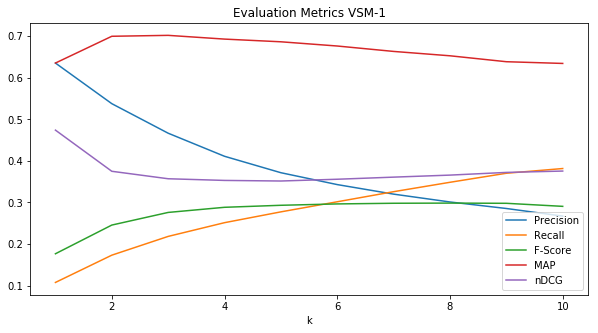

In [7]:
# from evaluationAllMetrics import Evaluation_metrics
Evaluation_metrics(doc_IDs_ordered_vsm1, query_ids, qrels,n_comp = 0,save_results=1, title_name="Evaluation Metrics VSM-1")

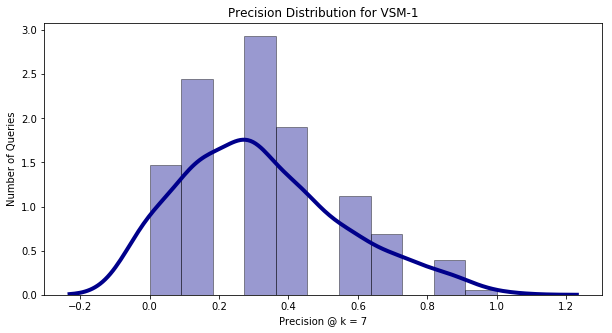

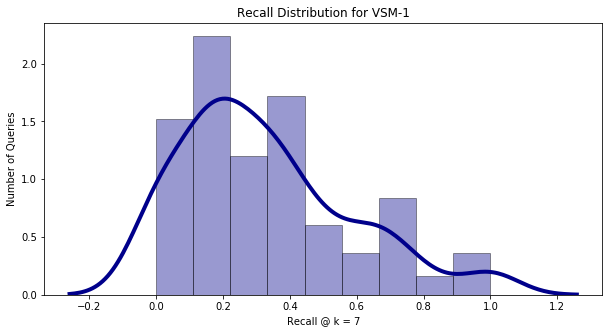

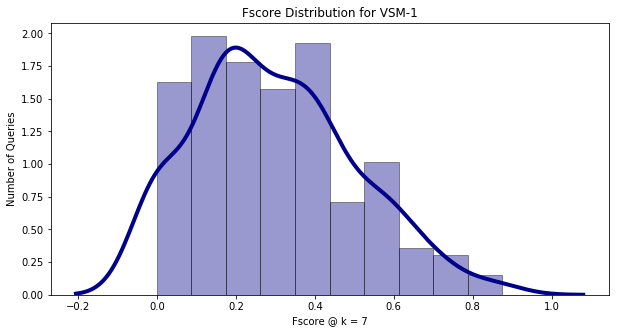

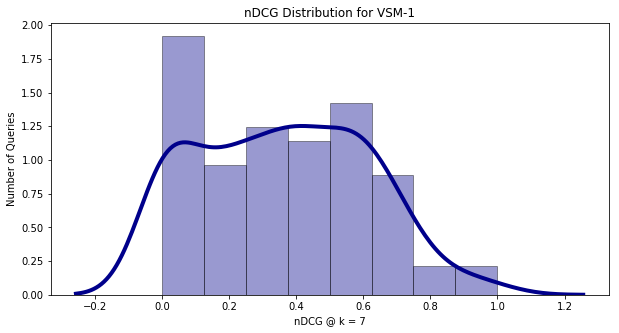

In [8]:
# from observations import run
q_precision_vsm1, q_recall_vsm1, q_fscore_vsm1, q_ndcg_vsm1 = run(qrels, doc_IDs_ordered_vsm1,queries,
                                                                      k = 7, model_name = 'VSM-1')

## 2. VSM-2
This model has additional preprocessing techniques like removing frequent words related to dataset, punctutation removing, number removals and so on... It is observed that VSM-2 model outperforms the VSM-1. So we use VSM-2 as out basemodel.

### 2.1 Data Preprocessing

In [9]:
# Following are the additional preprocessing used.
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"i'll", "i will", text)
    text = re.sub(r"she'll", "she will", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"here's", "here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"[^a-z]", " ", text) # This removes anything other than lower case letters(very imp)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    return text

def remove_punctuation(text):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation + '“' + '”'+'’' + '_'
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def lemmatize_words(text):
    lemmatizer = WordNetLemmatizer()
    wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
    pos_tagged_text = nltk.pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text])

In [10]:
# Apply the above preprocessing on to queries and docs

query_df = pd.DataFrame(queries,columns = ['query'])
docs_df = pd.DataFrame(docs_json).drop(['author','bibliography','id','title'],axis=1)

docs_df['preprocessed'] = docs_df['body'].str.lower()
query_df['preprocessed'] = query_df['query'].str.lower()

docs_df['preprocessed'] = docs_df['preprocessed'].apply(clean_text)
query_df['preprocessed'] = query_df['preprocessed'].apply(clean_text)

docs_df['preprocessed'] = docs_df['preprocessed'].apply(lambda text: remove_punctuation(text))
query_df['preprocessed'] = query_df['preprocessed'].apply(lambda text: remove_punctuation(text))

docs_df['preprocessed'] = docs_df['preprocessed'].apply(lambda text: remove_stopwords(text))
query_df['preprocessed'] = query_df['preprocessed'].apply(lambda text: remove_stopwords(text))

docs_df['preprocessed'] = docs_df['preprocessed'].apply(lambda text: lemmatize_words(text))
query_df['preprocessed'] = query_df['preprocessed'].apply(lambda text: lemmatize_words(text))

docs_df.head()

,body,preprocessed
0,experimental investigation of the aerodynamics...,experimental investigation aerodynamics wing s...
1,simple shear flow past a flat plate in an inco...,simple shear flow past flat plate incompressib...
2,the boundary layer in simple shear flow past a...,boundary layer simple shear flow past flat pla...
3,approximate solutions of the incompressible la...,approximate solution incompressible laminar bo...
4,one-dimensional transient heat conduction into...,one dimensional transient heat conduction doub...


In [11]:
# combining the documents and queries.
corpus = docs_df['preprocessed'].tolist() + query_df['preprocessed'].tolist()

### 2.2 Tfidf Representation

In [12]:
# we use sklearn tfidf vectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print("Total number of docs and queries included are {} and Vocabulary size is {}".format(X.shape[0],X.shape[1]))

feature_names = vectorizer.get_feature_names()
columns = ['doc_' + str(i) for i in range(1,X.shape[0]+1)]

tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
tfidf_df.head()

Total number of docs and queries included are 1625 and Vocabulary size is 5604


,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_1616,doc_1617,doc_1618,doc_1619,doc_1620,doc_1621,doc_1622,doc_1623,doc_1624,doc_1625
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbreviated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# documents tfidf representation 
tf_idf_docs_vsm2 = tfidf_df[columns[:len(docs_df)]].values

# queries tfidf representation
vec_rep_queries_vsm2 = tfidf_df[columns[len(docs_df):]].values

### 2.3 Ranking and Evaluation

In [14]:
# cosine similarity between documents and queries
cosine_sim_vsm2 = np.matmul(tf_idf_docs_vsm2.T, vec_rep_queries_vsm2)

# Documents are ordered based on cosine similarity
doc_IDs_ordered_vsm2 = (np.argsort(cosine_sim_vsm2,axis=0)+1)[::-1].T.tolist()

Precision, Recall and F-score @ 1 : 0.6933333333333334, 0.11813159596691133, 0.19345722168811094
MAP, nDCG @ 1 : 0.6933333333333334, 0.5274074074074074
Precision, Recall and F-score @ 2 : 0.5666666666666667, 0.18859036312567867, 0.26577595814690075
MAP, nDCG @ 2 : 0.7333333333333333, 0.4120470112357184
Precision, Recall and F-score @ 3 : 0.5007407407407409, 0.24088233127783326, 0.3022374292347652
MAP, nDCG @ 3 : 0.733703703703704, 0.3910062353907617
Precision, Recall and F-score @ 4 : 0.46111111111111114, 0.28726653227454285, 0.32769150280712667
MAP, nDCG @ 4 : 0.72320987654321, 0.3903096359644013
Precision, Recall and F-score @ 5 : 0.41155555555555584, 0.3132692600374572, 0.3281620307874807
MAP, nDCG @ 5 : 0.7205185185185184, 0.3903364853417083
Precision, Recall and F-score @ 6 : 0.37925925925925913, 0.3417134418666964, 0.3315977221122444
MAP, nDCG @ 6 : 0.7093382716049381, 0.3963771301503845
Precision, Recall and F-score @ 7 : 0.3561904761904765, 0.3688050070190457, 0.334063100576617

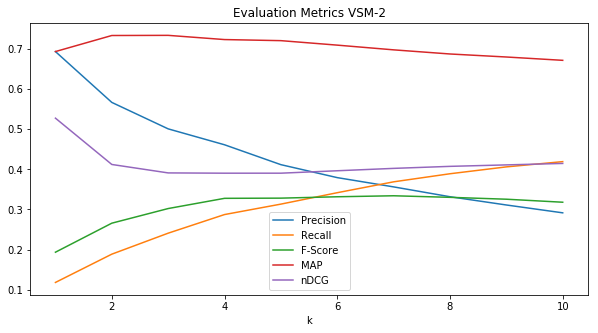

In [15]:
Evaluation_metrics(doc_IDs_ordered_vsm2, query_ids, qrels,n_comp = 0,save_results=1, title_name="Evaluation Metrics VSM-2")

### 2.4 Observations

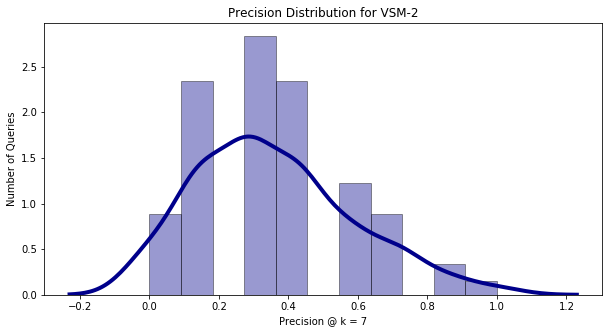

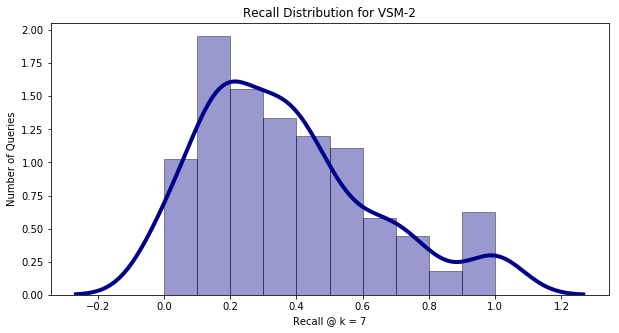

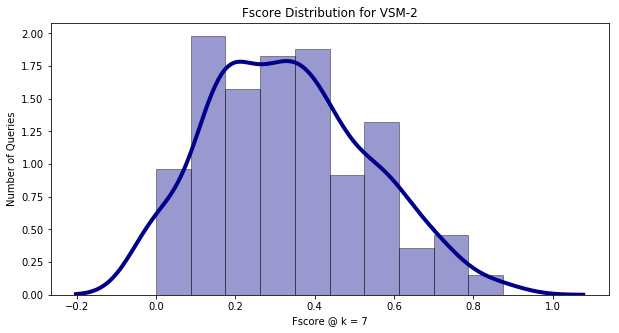

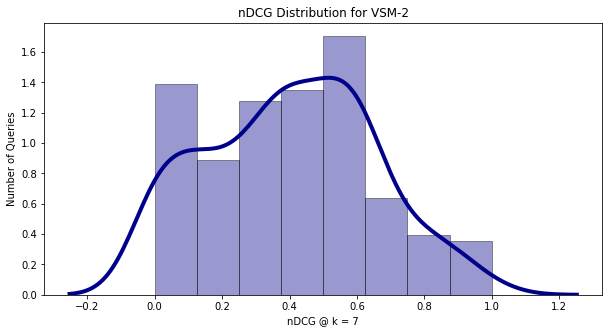

In [16]:
q_precision_vsm2, q_recall_vsm2, q_fscore_vsm2, q_ndcg_vsm2 = run(qrels, doc_IDs_ordered_vsm2,
                                                                 queries, k = 7, model_name = 'VSM-2')

### 2.5 VSM-1 Vs VSM-2
From below, we can observe that VSM-2 model outperforms the VSM-1 model in all the metrics. You could see that VSM-2 model decreases the count of lower precision or recall or ndcg or fscore and increases the count for the higher precision or recall or ndcg or fscore queries.

From now on VSM-2 is our baseline model to be compared with other models

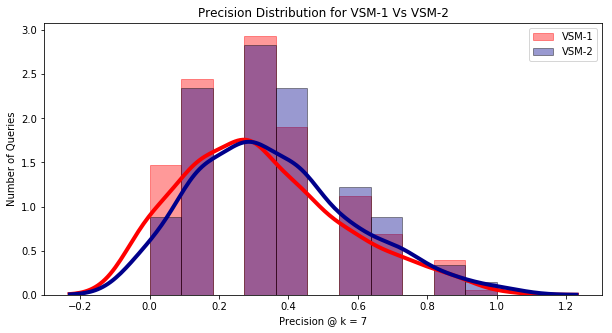

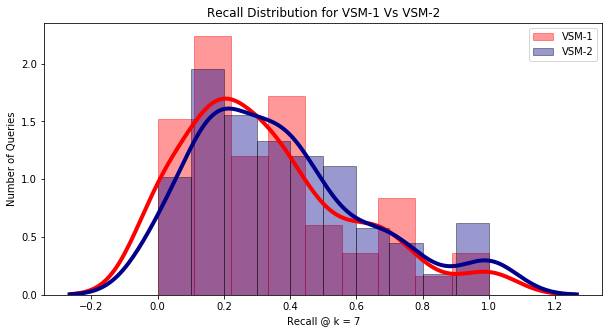

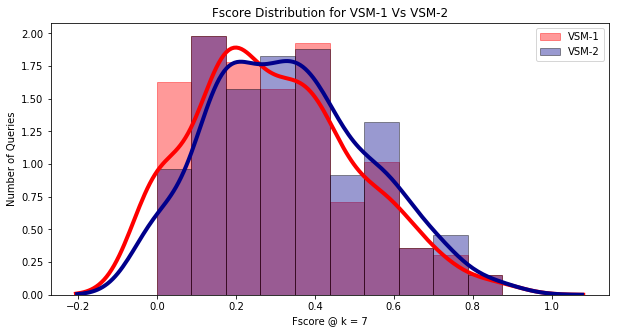

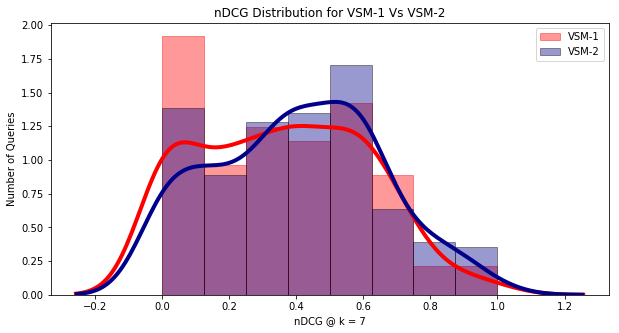

In [17]:
# from observations import run_comp
run_comp(q_precision_vsm1, q_precision_vsm2, q_recall_vsm1, q_recall_vsm2,
         q_fscore_vsm1, q_fscore_vsm2, q_ndcg_vsm1, q_ndcg_vsm2, k = 7, model1_name = 'VSM-1', model2_name = 'VSM-2')

In [18]:
# VSM-1 Vs VSM-2 (precision)
# from hypoTesting import hypothesis_test
hypothesis_test(q_precision_vsm1, q_precision_vsm2)

formula: t = -1.69241  p = 0.0912622


In [19]:
# VSM-1 Vs VSM-2 (recall)
hypothesis_test(q_recall_vsm1, q_recall_vsm2)

formula: t = -1.76362  p = 0.0784774


In [20]:
# VSM-1 Vs VSM-2 (f-score)
hypothesis_test(q_fscore_vsm1, q_fscore_vsm2)

formula: t = -1.90723  p = 0.0571297


In [21]:
# VSM-1 Vs VSM-2 (ndcg)
hypothesis_test(q_ndcg_vsm1, q_ndcg_vsm2)

formula: t = -1.75331  p = 0.0802332


## 3. LSA

### 3.1 TFIDF Vectorizer

In [22]:
corpus = docs_df['preprocessed'].tolist() + query_df['preprocessed'].tolist()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print("Total number of docs and queries included are {} and Vocabulary size is {}".format(X.shape[0],X.shape[1]))

feature_names = vectorizer.get_feature_names()
columns = ['doc_' + str(i) for i in range(1,X.shape[0]+1)]

tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
tf_idf_docs_lsa = tfidf_df[columns[:len(docs_df)]].values
vec_rep_queries_lsa = tfidf_df[columns[len(docs_df):]].values
tfidf_df.head()

Total number of docs and queries included are 1625 and Vocabulary size is 5604


,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_1616,doc_1617,doc_1618,doc_1619,doc_1620,doc_1621,doc_1622,doc_1623,doc_1624,doc_1625
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbreviated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2 Fine Tuning for n_components in LSA


LSA with 100 in progress


LSA with 200 in progress


LSA with 300 in progress


LSA with 400 in progress


LSA with 500 in progress


LSA with 600 in progress


LSA with 700 in progress


LSA with 800 in progress


LSA with 900 in progress


LSA with 1000 in progress



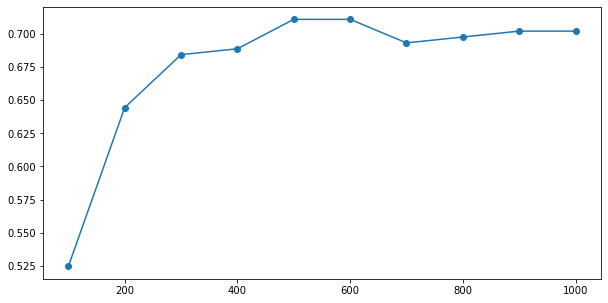

In [33]:
components_used = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
evaluator = Evaluation()
MAP = []
for n_comp in components_used:
    # using Singular value decomposition
    svd = TruncatedSVD(n_components=n_comp)
    svd.fit(tf_idf_docs_lsa.T)
    # transformed documents
    tr_docs_lsa = svd.transform(tf_idf_docs_lsa.T).T
    # transformed queries
    qr_tr_lsa = svd.transform(vec_rep_queries_lsa.T).T
    # cosine similarity
    cosine_sim_lsa = np.matmul(tr_docs_lsa.T, qr_tr_lsa)
    # documents ranking for queries using lsa
    doc_IDs_ordered_lsa = (np.argsort(cosine_sim_lsa,axis=0)+1)[::-1].T.tolist()
    print("\nLSA with "+str(n_comp)+" in progress\n")
    title = "LSA with "+ str(n_comp) + " latent variables"
    Evaluation_metrics(doc_IDs_ordered_lsa, query_ids, qrels,n_comp = n_comp,save_results=0, title_name=title, verbose=0)
    # Storing all the MAP values for each n_comp
    MAP.append(evaluator.meanAveragePrecision(doc_IDs_ordered_lsa, query_ids, qrels, k =1))
plt.figure(figsize=(10,5))
plt.plot(components_used, MAP)
plt.scatter(components_used, MAP)
plt.title('# Latent Variables Vs MAP')
plt.xlabel('Number of Latent Variables')
plt.ylabel('Mean Average Precision @ k = 1')
plt.show()

### 3.3 Final LSA with Optimal Latent Variables


LSA with 500 in progress

Precision, Recall and F-score @ 1 : 0.7022222222222222, 0.1173536578556399, 0.1924399056707949
MAP, nDCG @ 1 : 0.7022222222222222, 0.528888888888889
Precision, Recall and F-score @ 2 : 0.5822222222222222, 0.1916715284153062, 0.27092136374844666
MAP, nDCG @ 2 : 0.7377777777777778, 0.4169313317238138
Precision, Recall and F-score @ 3 : 0.5066666666666668, 0.24205221876144628, 0.3044356014329374
MAP, nDCG @ 3 : 0.734074074074074, 0.3914263905068746
Precision, Recall and F-score @ 4 : 0.4711111111111111, 0.29476549704863664, 0.3354939024331477
MAP, nDCG @ 4 : 0.730864197530864, 0.39686378631565533
Precision, Recall and F-score @ 5 : 0.4240000000000002, 0.3242360049845941, 0.33918210764140694
MAP, nDCG @ 5 : 0.7280493827160491, 0.3965376628812786
Precision, Recall and F-score @ 6 : 0.38518518518518535, 0.3487930615933748, 0.3376197292169455
MAP, nDCG @ 6 : 0.7158876543209872, 0.4009547984852482
Precision, Recall and F-score @ 7 : 0.36253968253968316, 0.37711738541

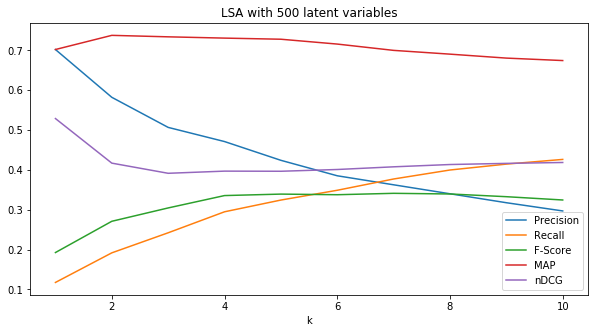

In [23]:
# best value, k = 500 latent dimensions
n_comp = 500
svd = TruncatedSVD(n_components=n_comp)
svd.fit(tf_idf_docs_lsa.T)
tr_docs_lsa = svd.transform(tf_idf_docs_lsa.T).T
qr_tr_lsa = svd.transform(vec_rep_queries_lsa.T).T
cosine_sim_lsa = np.matmul(tr_docs_lsa.T, qr_tr_lsa)
doc_IDs_ordered_lsa = (np.argsort(cosine_sim_lsa,axis=0)+1)[::-1].T.tolist()
print("\nLSA with "+str(n_comp)+" in progress\n")
title = "LSA with "+ str(n_comp) + " latent variables"
Evaluation_metrics(doc_IDs_ordered_lsa, query_ids, qrels,n_comp = n_comp,save_results=1, title_name=title)

### 3.4 Observations

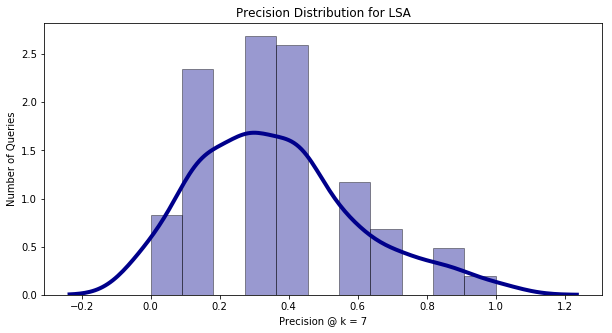

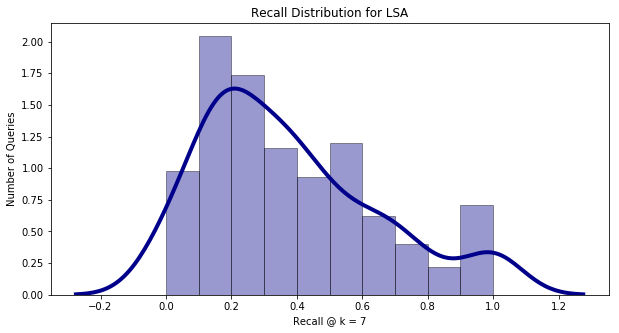

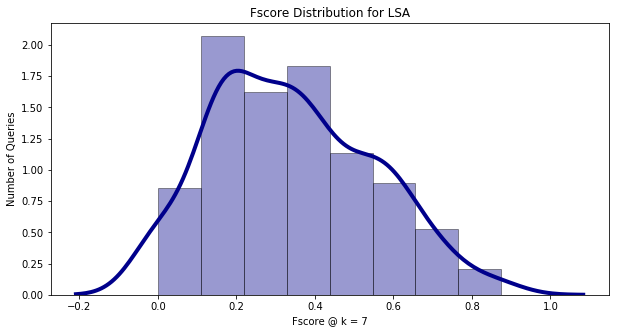

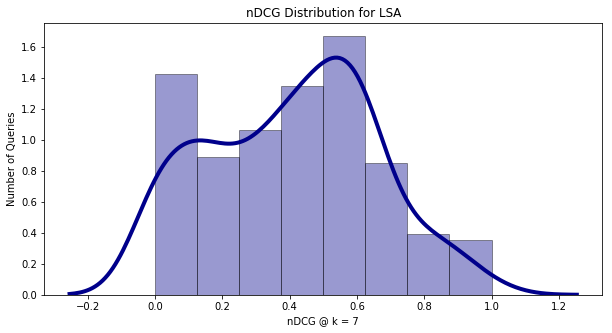

In [24]:
q_precision_lsa, q_recall_lsa, q_fscore_lsa, q_ndcg_lsa = run(qrels, doc_IDs_ordered_lsa,
                                                                 queries, k = 7, model_name = 'LSA')

### 3.5 VSM-2 Vs LSA
Seems not much improvement in performance, but we could see that LSA performed better than the VSM-2 almost in all the instants. But clear improvement in nDCG i.e LSA improved the ranking order and performed better than the VSM-2.

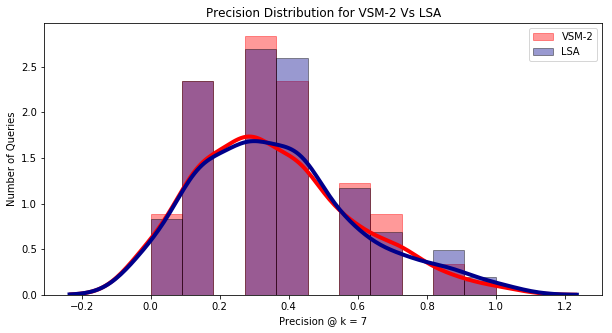

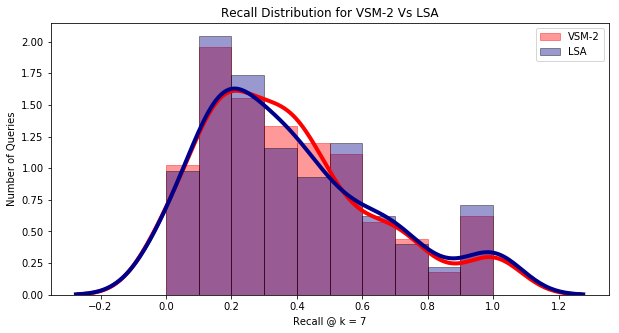

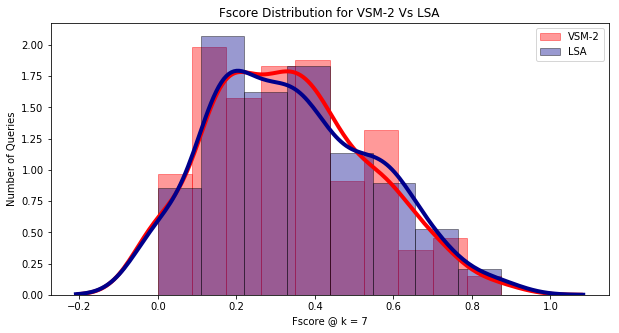

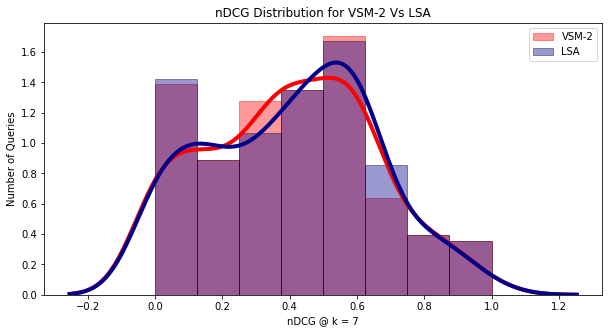

In [25]:
run_comp(q_precision_vsm2, q_precision_lsa, q_recall_vsm2, q_recall_lsa,
         q_fscore_vsm2, q_fscore_lsa, q_ndcg_vsm2, q_ndcg_lsa, k = 7, model1_name = 'VSM-2', model2_name = 'LSA')

### 3.6 Two Sample t-test

***Null Hypothesis*** : VSM2 and LSA are performing same

***Alternate Hypothesis*** : VSM2 and LSA are not performing same

***Results***: p-value > 0.05, so we do not have enough evidence to reject the Null Hypothesis

In [26]:
# Hypothesis Testing VSM-2 Vs LSA
print('Precision')
hypothesis_test(q_precision_vsm2, q_precision_lsa)

print('Recall')
hypothesis_test(q_recall_vsm2, q_recall_lsa)

print('FScore')
hypothesis_test(q_fscore_vsm2, q_fscore_lsa)

print('nDCG')
hypothesis_test(q_ndcg_vsm2, q_ndcg_lsa)

Precision
formula: t = -0.294462  p = 0.768541
Recall
formula: t = -0.331107  p = 0.740718
FScore
formula: t = -0.371351  p = 0.710552
nDCG
formula: t = -0.229063  p = 0.818924


### 4. Query Expansion
We try to expand the query by adding the similar words of the query.

### 4.1 Distributional Word Similarity

In [27]:
# using word-2-vec pretrained word embedding
from gensim.models import Word2Vec
corpus = docs_df['preprocessed'].tolist() + query_df['preprocessed'].tolist()
All_sentences = [sent.split(" ") for sent in corpus]

model = Word2Vec(min_count=1,
                window = 3,
                size = 500,
                sample = 6e-5)
t = time.time()
model.build_vocab(All_sentences, progress_per = 1000)
print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

t = time.time()

# training word embeddings on corpus
model.train(All_sentences, total_examples=model.corpus_count, epochs=50, report_delay=1)

print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

res = np.array(model.wv.most_similar(positive=["good"]))[:,0].tolist()[:5]
res

Time to build vocab: 0.0 mins
Time to train the model: 0.09 mins


['agreement', 'compare', 'result', 'comparison', 'prediction']

### 4.2 Query Expansion

In [28]:
def query_expansion(query, wv_model,v=1):
    """
    query : query to be expanded (a list of lists, where each sublist is a sentence)
    wv_model : word2vec trained model
    v : top v similar words taken into consideration
    """
    expanded_query = []
    for sent in query:
        
        for word in sent:
            
            try:
                expanded_query+=(np.array(wv_model.wv.most_similar(positive=[word],topn = v))[:,0].tolist())
            except:
                pass
    return " ".join(expanded_query)

query_df['expanded_query'] = query_df["preprocessed"].apply(lambda x: query_expansion([x.split(" ")], model))
query_df['expanded_query'] += query_df['preprocessed']
query_df.head()

,query,preprocessed,expanded_query
0,what similarity laws must be obeyed when const...,similarity law must obey construct aeroelastic...,law relation dirichlet key routine future nace...
1,what are the structural and aeroelastic proble...,structural aeroelastic problem associate fligh...,random future iterative equip boom encounter f...
2,what problems of heat conduction in composite ...,problem heat conduction composite slab solve far,iterative transfer energy slab composite ordin...
3,can a criterion be developed to show empirical...,criterion develop show empirically validity fl...,toroidal simple excellent keller consideration...
4,what chemical kinetic system is applicable to ...,chemical kinetic system applicable hypersonic ...,reaction electron electronic formula nosed ail...


### 4.3 TFIDF Representation

In [29]:
vectorizer = TfidfVectorizer()
corpus_qe = docs_df['preprocessed'].tolist() + query_df['expanded_query'].tolist()
X = vectorizer.fit_transform(corpus_qe)
print("Total number of docs and queries included are {} and Vocabulary size is {}".format(X.shape[0],X.shape[1]))

feature_names = vectorizer.get_feature_names()
columns = ['doc_' + str(i) for i in range(1,X.shape[0]+1)]

tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
tfidf_df.head()

Total number of docs and queries included are 1625 and Vocabulary size is 5825


,doc_1,doc_2,doc_3,doc_4,doc_5,doc_6,doc_7,doc_8,doc_9,doc_10,...,doc_1616,doc_1617,doc_1618,doc_1619,doc_1620,doc_1621,doc_1622,doc_1623,doc_1624,doc_1625
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abbreviated,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ability,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablate,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ablation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
tf_idf_docs_qe = tfidf_df[columns[:len(docs_df)]].values
vec_rep_queries_qe = tfidf_df[columns[len(docs_df):]].values
#= vectorizer.transform(query_df["expanded_query"].tolist()).T.todense()

### 4.4 Ranking and Evaluation

Precision, Recall and F-score @ 1 : 0.5244444444444445, 0.09432987410966841, 0.15287288972606994
MAP, nDCG @ 1 : 0.5244444444444445, 0.37037037037037035
Precision, Recall and F-score @ 2 : 0.45111111111111113, 0.14859006851632375, 0.2101677092095005
MAP, nDCG @ 2 : 0.5888888888888889, 0.3080465199333371
Precision, Recall and F-score @ 3 : 0.3999999999999998, 0.19107019599118819, 0.2402673531050809
MAP, nDCG @ 3 : 0.5937037037037036, 0.2995213514864515
Precision, Recall and F-score @ 4 : 0.36777777777777776, 0.2275341209551132, 0.2605823294755341
MAP, nDCG @ 4 : 0.5943209876543213, 0.30387258623915575
Precision, Recall and F-score @ 5 : 0.3351111111111114, 0.2586436287312876, 0.2701813518591639
MAP, nDCG @ 5 : 0.5909753086419759, 0.30670167833958845
Precision, Recall and F-score @ 6 : 0.31259259259259253, 0.2856233342109932, 0.2760361071395221
MAP, nDCG @ 6 : 0.5796913580246918, 0.31133783746282323
Precision, Recall and F-score @ 7 : 0.29206349206349236, 0.31121250792761795, 0.278385867

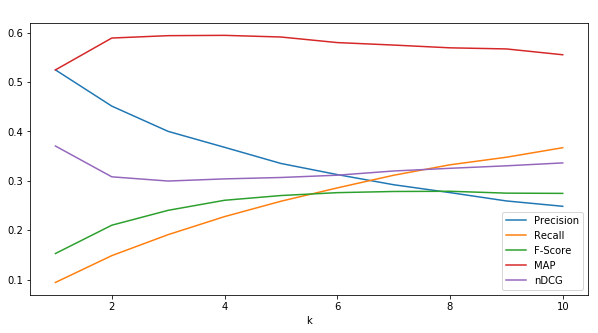

In [31]:
cosine_sim_qe = np.matmul(tf_idf_docs_qe.T, vec_rep_queries_qe)
doc_IDs_ordered_qe = (np.argsort(cosine_sim_qe,axis=0)+1)[::-1].T.tolist()
Evaluation_metrics(doc_IDs_ordered_qe, query_ids, qrels,n_comp = 0,save_results=1)

### 4.5 Observations

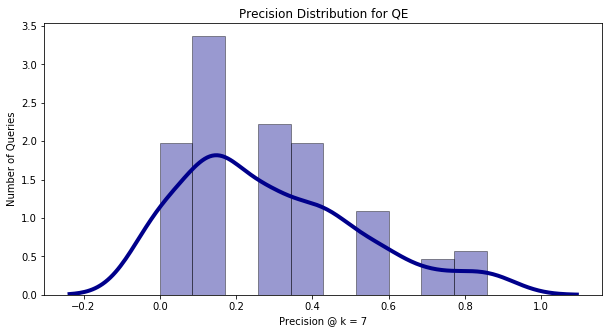

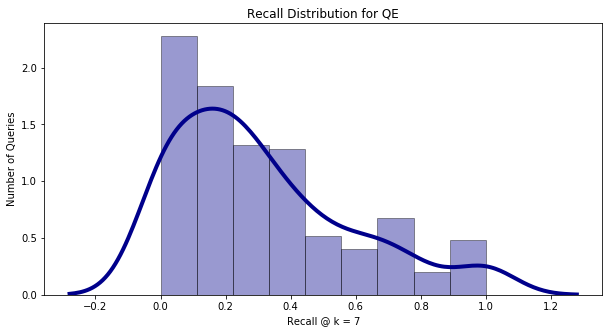

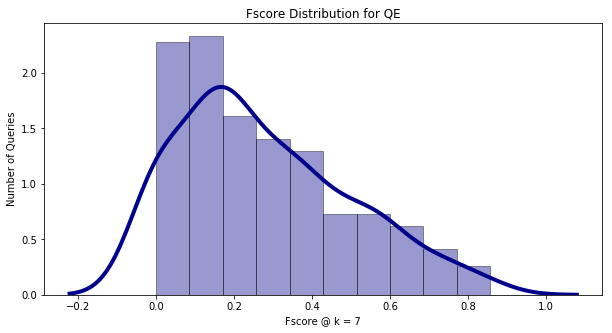

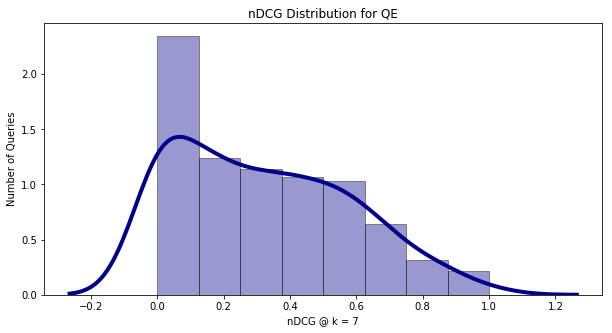

In [32]:
q_precision_qe, q_recall_qe, q_fscore_qe, q_ndcg_qe = run(qrels, doc_IDs_ordered_qe,
                                                                 queries, k = 7, model_name = 'QE')

### 4.6 Query Expansion(QE) Vs LSA
Clearly Query expansion performs worse than our basemodel(VSM-2). This is expected because word2vec we trained on has very small corpus. If we have enough corpus to train our word2vec model, that may improve the performance of the query expansion model. In this way, we expect atleast recall to get improved by the QE Model

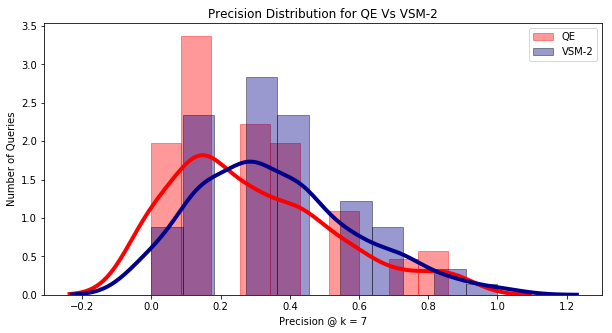

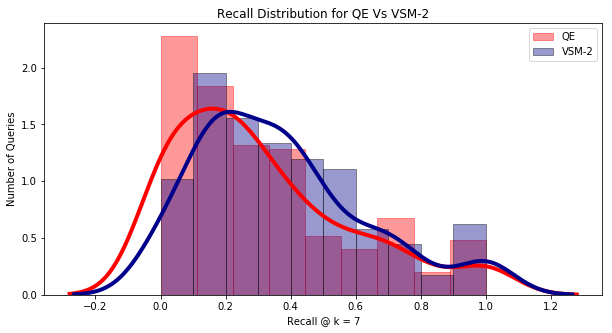

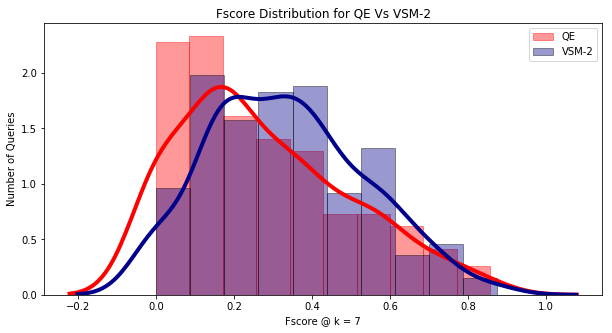

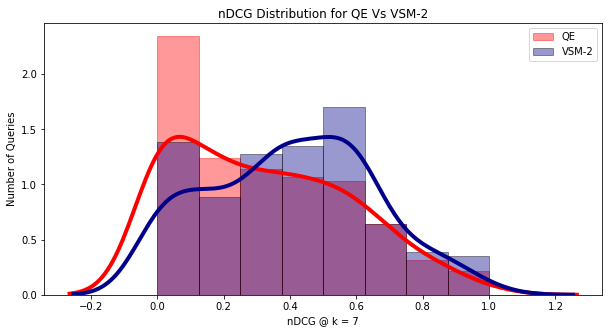

In [33]:
run_comp(q_precision_qe, q_precision_vsm2, q_recall_qe, q_recall_vsm2,
         q_fscore_qe, q_fscore_vsm2, q_ndcg_qe, q_ndcg_vsm2, k = 7, model1_name = 'QE', model2_name = 'VSM-2')

### 4.7 Few Examples
Following are the few examples where VSM model gave recall = 0 but the QE model gave non-zero recall.

In [34]:
# Info about Query 85
df = pd.DataFrame(qrels)
print("Expanded Query : ", query_df['expanded_query'][84])
print("Preprocessed Query : ", query_df['preprocessed'][84])
print("Words Added : ",query_df['expanded_query'][84].split(' ')[:10])
print("VSM Recall : ", q_recall_vsm2[84])
print("QE Recall : ", q_recall_qe[84])
print("Retrieved : ",doc_IDs_ordered_qe[84][:10])
print("Relevant : ", list(map(int, df[df['query_num'] == str(85)]['id'].tolist())))

Expanded Query :  nondimensional interferograms delay aluminium roughness layer injection dimensional nacelle tunnel windparameter seriously influence natural transition laminar turbulent flow model wind tunnel
Preprocessed Query :  parameter seriously influence natural transition laminar turbulent flow model wind tunnel
Words Added :  ['nondimensional', 'interferograms', 'delay', 'aluminium', 'roughness', 'layer', 'injection', 'dimensional', 'nacelle', 'tunnel']
VSM Recall :  0.0
QE Recall :  0.2
Retrieved :  [710, 80, 314, 7, 40, 1211, 96, 8, 43, 933]
Relevant :  [608, 406, 606, 710, 546]


In [35]:
# Info about Query 184
print("Expanded Query : ", query_df['expanded_query'][183])
print("Preprocessed Query : ", query_df['preprocessed'][183])
print("Words Added : ",query_df['expanded_query'][183].split(' ')[:5])
print("VSM Recall : ", q_recall_vsm2[183])
print("QE Recall : ", q_recall_qe[183])
print("Retrieved : ",doc_IDs_ordered_qe[183][:10])
print("Relevant : ", list(map(int, df[df['query_num'] == str(184)]['id'].tolist())))

Expanded Query :  provide progressively gust vehicle hyperbolicwork small oscillation entry motion
Preprocessed Query :  work small oscillation entry motion
Words Added :  ['provide', 'progressively', 'gust', 'vehicle', 'hyperbolicwork']
VSM Recall :  0.0
QE Recall :  0.125
Retrieved :  [882, 1289, 207, 716, 779, 164, 1348, 717, 1345, 639]
Relevant :  [32, 67, 715, 717, 716, 499, 1379, 639]


## 5. KMeans Clustering


### 5.1 Tuning for number of Clusters

For n_clusters = 2, silhouette score is 0.012010334633647262)
For n_clusters = 3, silhouette score is 0.013060167237340098)
For n_clusters = 4, silhouette score is 0.014066126359409153)
For n_clusters = 5, silhouette score is 0.016208334735011674)
For n_clusters = 6, silhouette score is 0.014554924441870383)
For n_clusters = 7, silhouette score is 0.01710175980153943)
For n_clusters = 8, silhouette score is 0.016135492073706303)
For n_clusters = 9, silhouette score is 0.016531108414271977)
For n_clusters = 10, silhouette score is 0.019115354339278322)


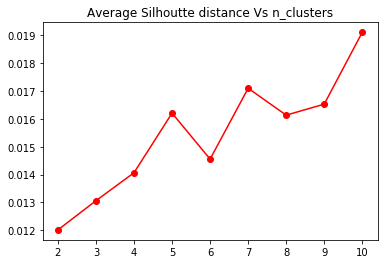

In [51]:
# tf-idf representation of documents
df_cluster = tf_idf_docs_lsa.T
# silhoutte scores to find the appropriate 
sil_scores = []
# tuning number of clusters using grid search, from 2 to 11
for n_clusters in range(2,11):
    # Applying K-means
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_cluster)
    # finding cluster centers
    centers = clusterer.cluster_centers_

    score = silhouette_score(df_cluster, preds)
    sil_scores.append(score)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
plt.plot(list(range(2,11)),sil_scores, marker='o',color= 'r')
plt.title("Average Silhoutte distance Vs n_clusters")
plt.show()

*** Observation: ***
Taking k = 6, clusters gave decent trade-off between retrieval time and other evaluation metrics. But using k = 10 gave huge trade-off between retrieval time and other metrics.

### 5.2 Distortion Calculations

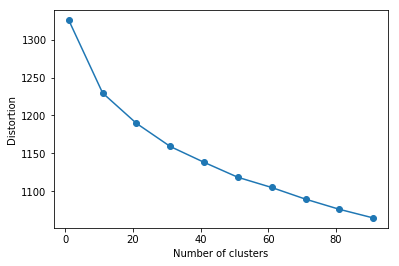

In [37]:
# calculate distortion for a range of number of cluster
distortions = []
# Elbow plot to find the optimal clusters
for i in range(1, 100, 10):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(tf_idf_docs_lsa.T)
    distortions.append(km.inertia_)

# plot
plt.plot( list(range(1,100,10)), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### 5.3 Optimal number of clusters
From above plots, we could say that optimal number of clusters is n = 6 and n = 9. But if we choose n = 9 trade-off for precision, recall, other metrics score is huge and retrieval time for n=6 and n=9 is very similar. So we choose number of cluster, n = 6 as optimal number of clusters

In [38]:
# combining the query words and document words to avoid oov.
corpus = docs_df['preprocessed'].tolist() + query_df['preprocessed'].tolist()
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print("Total number of docs and queries included are {} and Vocabulary size is {}".format(X.shape[0],X.shape[1]))

feature_names = vectorizer.get_feature_names()
columns = ['doc_' + str(i) for i in range(1,X.shape[0]+1)]

tfidf_df = pd.DataFrame(X.T.todense(), index=feature_names, columns=columns)
tf_idf_docs_km= tfidf_df[columns[:len(docs_df)]].values # final representations of documents
vec_rep_queries_km= tfidf_df[columns[len(docs_df):]].values # final representations of queries

Total number of docs and queries included are 1625 and Vocabulary size is 5604


In [39]:
# Best k = 6
km = KMeans(n_clusters= 6, random_state=0)
# fitting KMC on documents
km.fit(tf_idf_docs_km.T)
km.cluster_centers_.shape

(6, 5604)

In [40]:
cluster_doc_ids = {}
# assigning documents to various clusters
for i in range(1400):
    try :
        cluster_doc_ids[km.labels_[i]] += [i]
    except :
        cluster_doc_ids[km.labels_[i]] = [i]

### 5.4 Average Retrieval Time

In [41]:
# normal method of retrieval
tic = time.time()
# for finding the average retrieval time for a query.
# iterating over queries
for j in range(200):
    cosine_sim_clust = []
    # iterating over all documents
    for i in range(1400):
        # cosine similarity
        cosine_sim_clust.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    cosine_sim_clust = np.array(cosine_sim_clust)
    doc_IDs_ordered_clust = (np.argsort(cosine_sim_clust,axis=0)+1)[::-1].T.tolist()
toc = time.time()
print("without clustering, Average Retrieval time : "+str((toc-tic)/200))

# clustering method
tic = time.time()
doc_IDs_ordered_kmeans = []
# iterating over queries
for j in range(200):
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, km.cluster_centers_.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clust = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
    doc_IDs_ordered_kmeans.append(doc_IDs_ordered_clust)
    #doc_IDs_ordered = np.array(cluster_doc_ids[cluster])[doc_IDs_ordered_clust]+1
toc = time.time()
print("clustering method, Retrieval time : "+str((toc-tic)/200))

without clustering, Average Retrieval time : 0.010880074501037597
clustering method, Retrieval time : 0.005468959808349609


### 5.5 Observations and hypothesis testing

In [42]:
# we store the retrieval time taken for each query and store them as a list
without_clust = []
# iterating over 200 queries
for j in range(200):
    tic = time.time()
    cosine_sim = []
    for i in range(1400):
        cosine_sim.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    cosine_sim = np.array(cosine_sim)
    doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()
    toc = time.time()
    without_clust.append((toc-tic))
    
# print(len(doc_IDs_ordered))

#print("without clustering, Average Retrieval time : "+str((toc-tic)/200))

with_clust = []
# clustering method
for j in range(200):
    tic = time.time()
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, km.cluster_centers_.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clus = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
    doc_IDs_ordered = np.array(cluster_doc_ids[cluster])[doc_IDs_ordered_clus]+1
    toc = time.time()
    with_clust.append((toc-tic))

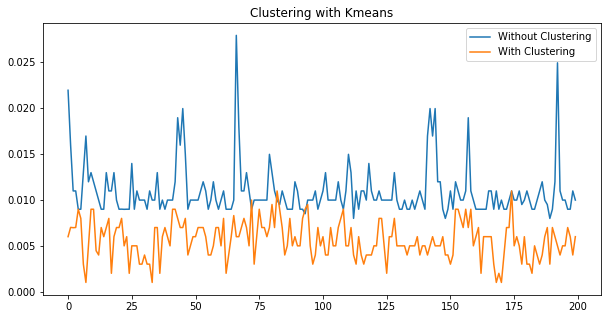

In [43]:
# plot
plt.figure(figsize = (10,5))
plt.title('Clustering with Kmeans')
plt.plot(range(200), without_clust, label = 'Without Clustering')
plt.plot(range(200), with_clust, label = 'With Clustering')
plt.legend()
plt.show()

In [44]:
# hypothesis testing
hypothesis_test(without_clust, with_clust)

formula: t = 21.5217  p = 1.62984e-66


## 6 Topic Modelling using LDA

### 6.1 LDA
We chose number of topics same as above kmeans clustering, note that this can also be tuned appropriately

In [45]:
cv = CountVectorizer(max_df = 0.95, min_df = 2, stop_words = 'english')
dtm = cv.fit_transform(docs_df["preprocessed"])
# LDA
LDA = LatentDirichletAllocation(n_components=6, random_state = 42)
LDA.fit(dtm)
topic_results = LDA.transform(dtm)
docs_df["LDA_topics"] = topic_results.argmax(axis = 1)
docs_df.head()

,body,preprocessed,LDA_topics
0,experimental investigation of the aerodynamics...,experimental investigation aerodynamics wing s...,2
1,simple shear flow past a flat plate in an inco...,simple shear flow past flat plate incompressib...,5
2,the boundary layer in simple shear flow past a...,boundary layer simple shear flow past flat pla...,5
3,approximate solutions of the incompressible la...,approximate solution incompressible laminar bo...,5
4,one-dimensional transient heat conduction into...,one dimensional transient heat conduction doub...,0


### 6.2 Average Retrieval Time

In [46]:
# assigning documents to a topic
cluster_doc_ids = {}
for i in range(1400):
    try :
        cluster_doc_ids[docs_df["LDA_topics"][i]] += [i]
    except :
        cluster_doc_ids[docs_df["LDA_topics"][i]] = [i]
        
cluster_centres = np.zeros((6,5604))
for i in range(6):
    cluster_centres[i,:] = np.mean(tf_idf_docs_km[:,cluster_doc_ids[i]], axis = 1)

In [47]:
# normal method of retrieval
without_clust_lda = []
with_clust_lda = []
tic = time.time()
for j in range(200):
    cosine_sim = []
    for i in range(1400):
        cosine_sim.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    cosine_sim = np.array(cosine_sim)
    doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()
# print(len(doc_IDs_ordered))
toc = time.time()
print("without clustering, Average Retrieval time : "+str((toc-tic)/200))

# clustering method
tic = time.time()
for j in range(200):
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, cluster_centres.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clus = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
toc = time.time()
print("clustering method, Retrieval time : "+str((toc-tic)/200))

without clustering, Average Retrieval time : 0.010894849300384521
clustering method, Retrieval time : 0.006481443643569946


### 6.3 Results and Observations
As from above retrieval times with and without clustering. Average retrieval time for with lda is lesser than without lda retrieval time (almost for all the queries) but in case of clustering using Kmeans we have clearly around 50 - 70% decrease in the retrieval time.

In [48]:
# we store the retrieval time taken for each query and store them as a list
without_clust_lda = [] 
with_clust_lda = []

for j in range(200):
    cosine_sim = []
    tic = time.time()
    for i in range(1400):
        cosine_sim.append(np.matmul(tf_idf_docs_km[:,i].T, vec_rep_queries_km[:,j]))
    cosine_sim = np.array(cosine_sim)
    doc_IDs_ordered = (np.argsort(cosine_sim,axis=0)+1)[::-1].T.tolist()
    toc = time.time()
    without_clust_lda.append((toc-tic))

# clustering method
for j in range(200):
    tic = time.time()
    cluster = np.argmax(np.matmul(vec_rep_queries_km[:,j].T, cluster_centres.T))
    cluster_docs = tf_idf_docs_km[:, cluster_doc_ids[cluster]]
    cosine_sim = np.matmul(cluster_docs.T,vec_rep_queries_km[:,0])
    doc_IDs_ordered_clus = (np.argsort(cosine_sim,axis=0))[::-1].T.tolist()
#     doc_IDs_ordered = np.array(cluster_doc_ids[cluster])[doc_IDs_ordered_clus]+1
    toc = time.time()
    with_clust_lda.append((toc-tic))

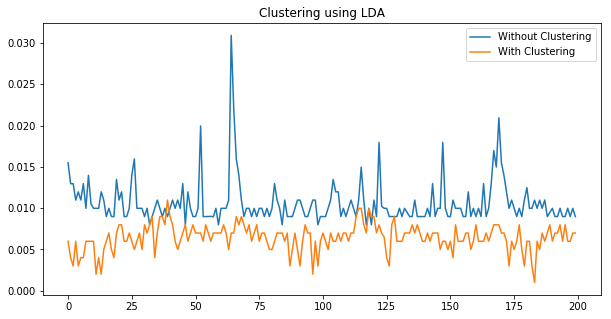

In [49]:
# plot
plt.figure(figsize = (10,5))
plt.title('Clustering using LDA')
plt.plot(range(200), without_clust_lda, label = 'Without Clustering')
plt.plot(range(200), with_clust_lda, label = 'With Clustering')
plt.legend()
plt.show()